In [5]:
# (1)  Load the packages needed for the analysis
library(lubridate) # to help with the date
library(ggplot2) # pretty plots
library(forecast)
library(tseries) # for time series analysis

In [6]:
# (2)  Bring in the raw data and take a look at it
data <- read.csv('cdma_data_gasoline.csv')
data$TSTAMP <- as.Date(data$TSTAMP, "%m-%d-%Y")

cdma.data.attempts <- data$CDMA_VOICE_ATTEMPTS
gas.data <- data$Gasoline
usage.data <- data$VOICE_USAGE

In [7]:
# Correlation between CDMA data attempts and US Gas Spending
cor(cdma.data.attempts, gas.data, use = "complete.obs")

[1] 0.7390368

In [8]:
# Correlation between CDMA data attempts and CDMA Data Usage
cor(cdma.data.attempts, usage.data, use = "complete.obs")

[1] 0.9811974

In [9]:
# Prewhiten Gasoline data with ARIMA filter
gas.arima.filter <- auto.arima(ts(gas.data, frequency = 12))
gas.arima.filter

Series: ts(gas.data, frequency = 12) 
ARIMA(0,1,1)(1,0,0)[12] 

Coefficients:
         ma1    sar1
      0.2664  0.8256
s.e.  0.1523  0.0641

sigma^2 estimated as 2000676:  log likelihood=-517.62
AIC=1041.23   AICc=1041.67   BIC=1047.47

In [10]:
# Prewhiten CDMA Data Usage data with ARIMA filter
usage.arima.filter <- auto.arima(ts(usage.data, frequency = 12))
usage.arima.filter

Series: ts(usage.data, frequency = 12) 
ARIMA(1,1,0)(1,0,0)[12] 

Coefficients:
          ar1    sar1
      -0.5769  0.5552
s.e.   0.1193  0.1353

sigma^2 estimated as 4.639e+15:  log likelihood=-1149.27
AIC=2304.55   AICc=2304.98   BIC=2310.78

In [11]:
# The residuals are the filtered gas data
gas.filt <- residuals(gas.arima.filter)

In [12]:
# The residuals are the filtered usage data
usage.filt <- residuals(usage.arima.filter)


	Shapiro-Wilk normality test

data:  residuals(gas.arima.filter)
W = 0.98613, p-value = 0.7285


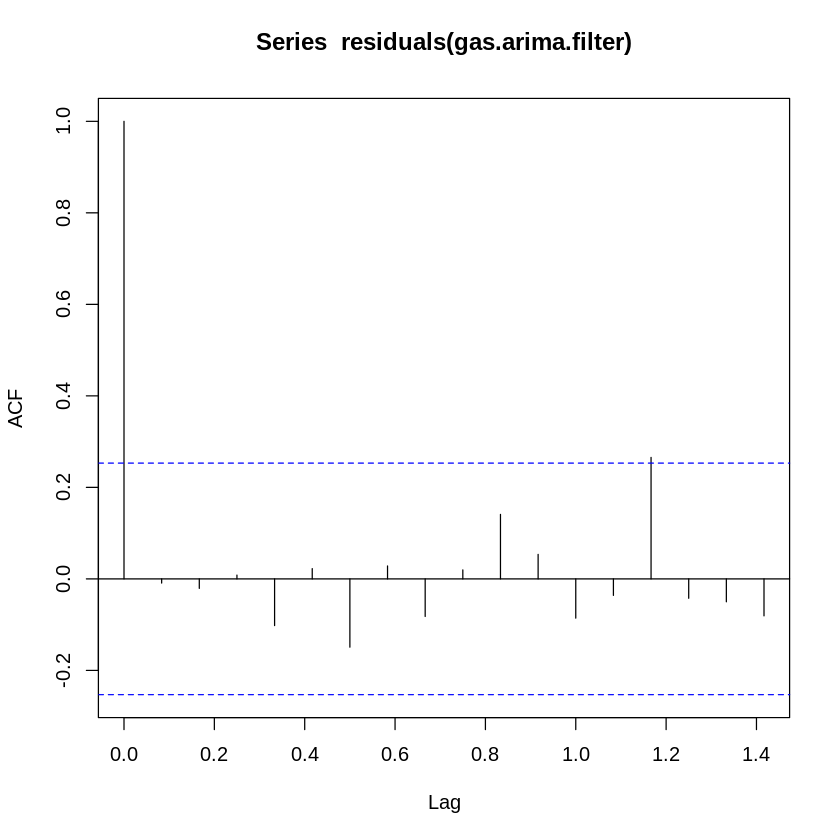

In [14]:
# Verifying the residuals expose the noise properties
acf(residuals(gas.arima.filter))
shapiro.test(residuals(gas.arima.filter))


	Shapiro-Wilk normality test

data:  residuals(usage.arima.filter)
W = 0.98141, p-value = 0.4911


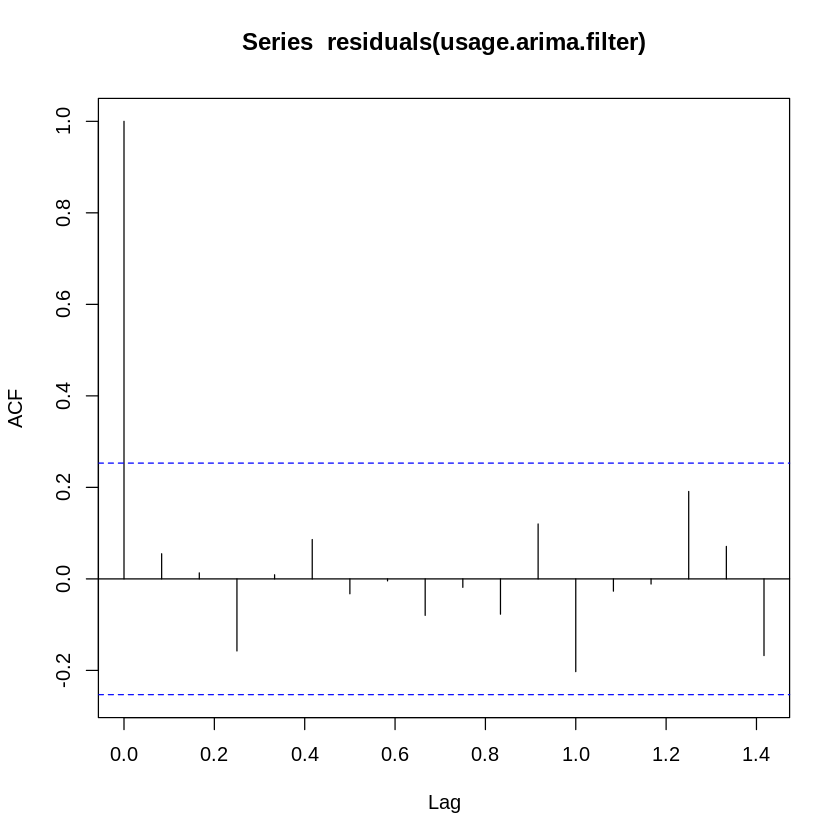

In [15]:
# Verifying the residuals expose the noise properties
acf(residuals(usage.arima.filter))
shapiro.test(residuals(usage.arima.filter))

In [19]:
# Filter the CDMA attempts data using the ARIMA filters
attempts.data.gas.filt <- residuals(Arima(cdma.data.attempts,
                                   order = c(0, 1, 1),
                                   seasonal = list(order = c(1, 0, 0), period = 12),
                                   fixed = c(0.2664, 0.8256)))

attempts.data.usage.filt <- residuals(Arima(cdma.data.attempts,
                                          order = c(1, 1, 0),
                                          seasonal = list(order = c(1, 0, 0), period = 12),
                                          fixed = c(-0.5769, 0.5552)))

In [20]:
# Apply traditional correlation to the filtered data set
cor(attempts.data.gas.filt, gas.filt, use = "complete.obs")

[1] 0.1625804

In [21]:
# Apply traditional correlation to the filtered data set
cor(attempts.data.usage.filt, usage.filt, use = "complete.obs")

[1] 0.776827